In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import stat
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose  
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults

In [2]:
# Evaluate model for other healthcare buildings

In [3]:
bmd = pd.read_csv('building_metadata.csv')
hlth = bmd[bmd['primary_use']=='Healthcare']
hlth.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 208 to 1388
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      23 non-null     int64  
 1   building_id  23 non-null     int64  
 2   primary_use  23 non-null     object 
 3   square_feet  23 non-null     int64  
 4   year_built   8 non-null      float64
 5   floor_count  1 non-null      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 1.3+ KB


In [4]:
hlth

,site_id,building_id,primary_use,square_feet,year_built,floor_count
208,2,208,Healthcare,36904,1934.0,NaN
365,3,365,Healthcare,819577,1922.0,NaN
455,3,455,Healthcare,29192,2014.0,NaN
535,3,535,Healthcare,15000,2010.0,NaN
547,3,547,Healthcare,23903,NaN,NaN
548,3,548,Healthcare,9813,2010.0,NaN
556,3,556,Healthcare,450000,2012.0,NaN
670,5,670,Healthcare,18471,1966.0,1.0
1072,13,1072,Healthcare,305000,NaN,NaN
1207,13,1207,Healthcare,74443,NaN,NaN


In [5]:
hlth_bld_id_list = hlth['building_id'].tolist()

In [6]:
# List of all healtcare buildings
hlth_bld_id_list

[208,
 365,
 455,
 535,
 547,
 548,
 556,
 670,
 1072,
 1207,
 1208,
 1209,
 1241,
 1243,
 1245,
 1269,
 1282,
 1285,
 1286,
 1300,
 1303,
 1313,
 1388]

In [7]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [8]:
full_df = pd.read_csv('train.csv',index_col='timestamp',parse_dates=True, infer_datetime_format=True)

In [9]:
full_df = reduce_mem_usage(full_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)


In [10]:
#Chooosing only electricty
full_df = full_df[full_df['meter']==0]

In [11]:
health_df_full = full_df[full_df.building_id.isin(hlth_bld_id_list)]

In [12]:
health_df_full

,building_id,meter,meter_reading
timestamp,,,
2016-01-01 00:00:00,208,0,77.290001
2016-01-01 00:00:00,365,0,1139.520020
2016-01-01 00:00:00,455,0,10.600000
2016-01-01 00:00:00,535,0,22.459999
2016-01-01 00:00:00,547,0,21.889999
...,...,...,...
2016-12-31 23:00:00,1285,0,193.000000
2016-12-31 23:00:00,1286,0,370.320007
2016-12-31 23:00:00,1300,0,49.509102


In [13]:
health_df_full = health_df_full.drop('meter', axis = 1)

In [14]:
health_df_full.index

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 00:00:00',
               '2016-01-01 00:00:00', '2016-01-01 00:00:00',
               '2016-01-01 00:00:00', '2016-01-01 00:00:00',
               '2016-01-01 00:00:00', '2016-01-01 00:00:00',
               '2016-01-01 00:00:00', '2016-01-01 00:00:00',
               ...
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=184345, freq=None)

In [15]:
# Making a huge pivot table -> columns are each leathcare building
health_df_piv = pd.pivot_table(health_df_full, index=health_df_full.index, columns='building_id')

In [16]:
health_df_piv

meter_reading                                     \
building_id                  208          365        455        535    
timestamp                                                              
2016-01-01 00:00:00     77.290001  1139.520020  10.600000  22.459999   
2016-01-01 01:00:00     87.089996  1122.719971   9.770000  22.120001   
2016-01-01 02:00:00     90.510002  1096.800049  10.120000  23.440001   
2016-01-01 03:00:00     83.660004  1098.959961   9.580000  26.150000   
2016-01-01 04:00:00     89.550003  1105.920044  10.250000  26.400000   
...                           ...          ...        ...        ...   
2016-12-31 19:00:00     38.230000  1270.319946  60.689999  45.349998   
2016-12-31 20:00:00     39.459999  1281.359985  60.509998  47.139999   
2016-12-31 21:00:00     28.350000  1296.239990  59.799999  45.520000   
2016-12-31 22:00:00     27.309999  1291.439941  60.029999  45.840000   
2016-12-31 23:00:00     27.639999  1277.760010  62.180000  46.759998   

                                                                      \
building_id               547    548          556   670         1207   
timestamp                                                              
2016-01-01 00:00:00  21.889999   8.97  1013.780029   8.0  150.557007   
2016-01-01 01:00:00  24.110001   9.49   988.380005  14.9  150.557007   
2016-01-01 02:00:00  23.990000   9.52   996.250000  11.2  151.167007   
2016-01-01 03:00:00  23.950001   9.04   966.219971  11.4  150.645004   
2016-01-01 04:00:00  24.219999   9.72   984.390015  11.0  150.811005   
...                        ...    ...          ...   ...         ...   
2016-12-31 19:00:00  31.330000  19.27  1225.359985  16.0  165.285995   
2016-12-31 20:00:00  32.380001  18.84  1178.640015  16.0  166.059998   
2016-12-31 21:00:00  31.620001  19.00  1187.449951  16.0  165.654007   
2016-12-31 22:00:00  32.570000  20.49  1159.839966  14.6  163.789001   
2016-12-31 23:00:00  32.000000  18.99  1156.589966  11.3  163.723999   

                                 ...                                   \
building_id                1208  ...        1241        1243     1245   
timestamp                        ...                                    
2016-01-01 00:00:00  186.531998  ...  234.179993  132.992996  25.4375   
2016-01-01 01:00:00  186.531998  ...  294.156006  162.729996  24.0312   
2016-01-01 02:00:00  183.479004  ...  354.152008  126.353996  25.7188   
2016-01-01 03:00:00  184.302994  ...  294.121002  155.309998  22.2188   
2016-01-01 04:00:00  183.656998  ...  294.101990  113.105003  21.8125   
...                         ...  ...         ...         ...      ...   
2016-12-31 19:00:00  191.494995  ...  262.000000  163.959000  20.0625   
2016-12-31 20:00:00  188.776993  ...  252.000000  159.632004  23.0312   
2016-12-31 21:00:00  189.929993  ...  252.000000  167.992004  21.1250   
2016-12-31 22:00:00  186.824997  ...  257.000000  167.076004  23.8750   
2016-12-31 23:00:00  186.628006  ...  260.000000  159.804001  25.1562   

                                                                     \
building_id               1269   1282   1285        1286       1300   
timestamp                                                             
2016-01-01 00:00:00  20.066200  537.0  198.0  338.109985  53.085499   
2016-01-01 01:00:00  21.890301  512.0  227.0  324.510010  49.849701   
2016-01-01 02:00:00  19.709000  541.0  209.0  323.820007  51.382500   
2016-01-01 03:00:00  20.181700  522.0  199.0  318.720001  50.299801   
2016-01-01 04:00:00  22.221500  531.0  177.0  314.950012  51.066200   
...                        ...    ...    ...         ...        ...   
2016-12-31 19:00:00  29.116400  546.0  194.0  373.799988  56.260399   
2016-12-31 20:00:00  29.281200  537.0  195.0  367.019989  52.562401   
2016-12-31 21:00:00  30.658199  536.0  218.0  376.089996  53.851799   
2016-12-31 22:00:00  29.225700  534.0  198.0  366.230011  52.051498   
2016-12-31 23:00:00  27.266100  526.0  193.0  370.320007

In [17]:
health_df_piv.columns

MultiIndex([('meter_reading',  208),
            ('meter_reading',  365),
            ('meter_reading',  455),
            ('meter_reading',  535),
            ('meter_reading',  547),
            ('meter_reading',  548),
            ('meter_reading',  556),
            ('meter_reading',  670),
            ('meter_reading', 1207),
            ('meter_reading', 1208),
            ('meter_reading', 1209),
            ('meter_reading', 1241),
            ('meter_reading', 1243),
            ('meter_reading', 1245),
            ('meter_reading', 1269),
            ('meter_reading', 1282),
            ('meter_reading', 1285),
            ('meter_reading', 1286),
            ('meter_reading', 1300),
            ('meter_reading', 1303),
            ('meter_reading', 1313)],
           names=[None, 'building_id'])

In [18]:
health_df_piv = health_df_piv.resample('H').backfill()

In [19]:
health_df_piv.index

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 01:00:00',
               '2016-01-01 02:00:00', '2016-01-01 03:00:00',
               '2016-01-01 04:00:00', '2016-01-01 05:00:00',
               '2016-01-01 06:00:00', '2016-01-01 07:00:00',
               '2016-01-01 08:00:00', '2016-01-01 09:00:00',
               ...
               '2016-12-31 14:00:00', '2016-12-31 15:00:00',
               '2016-12-31 16:00:00', '2016-12-31 17:00:00',
               '2016-12-31 18:00:00', '2016-12-31 19:00:00',
               '2016-12-31 20:00:00', '2016-12-31 21:00:00',
               '2016-12-31 22:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=8784, freq='H')

In [20]:
np.isinf(health_df_piv.all()).sum()

0

In [21]:
np.isnan(health_df_piv.all()).sum()

0

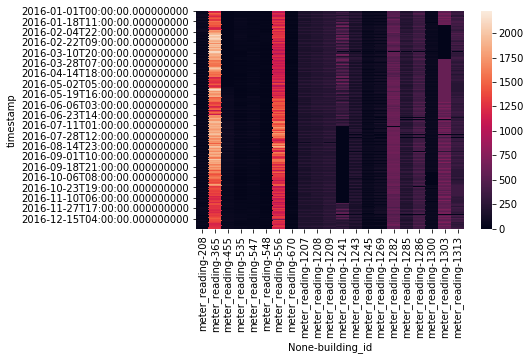

In [22]:
sns.heatmap(health_df_piv)

In [23]:
#Pretty massive variation in energy usage by building...
# As we knew before, 556 and 365 have much higher energy consumptions
# May have to make separate model for these

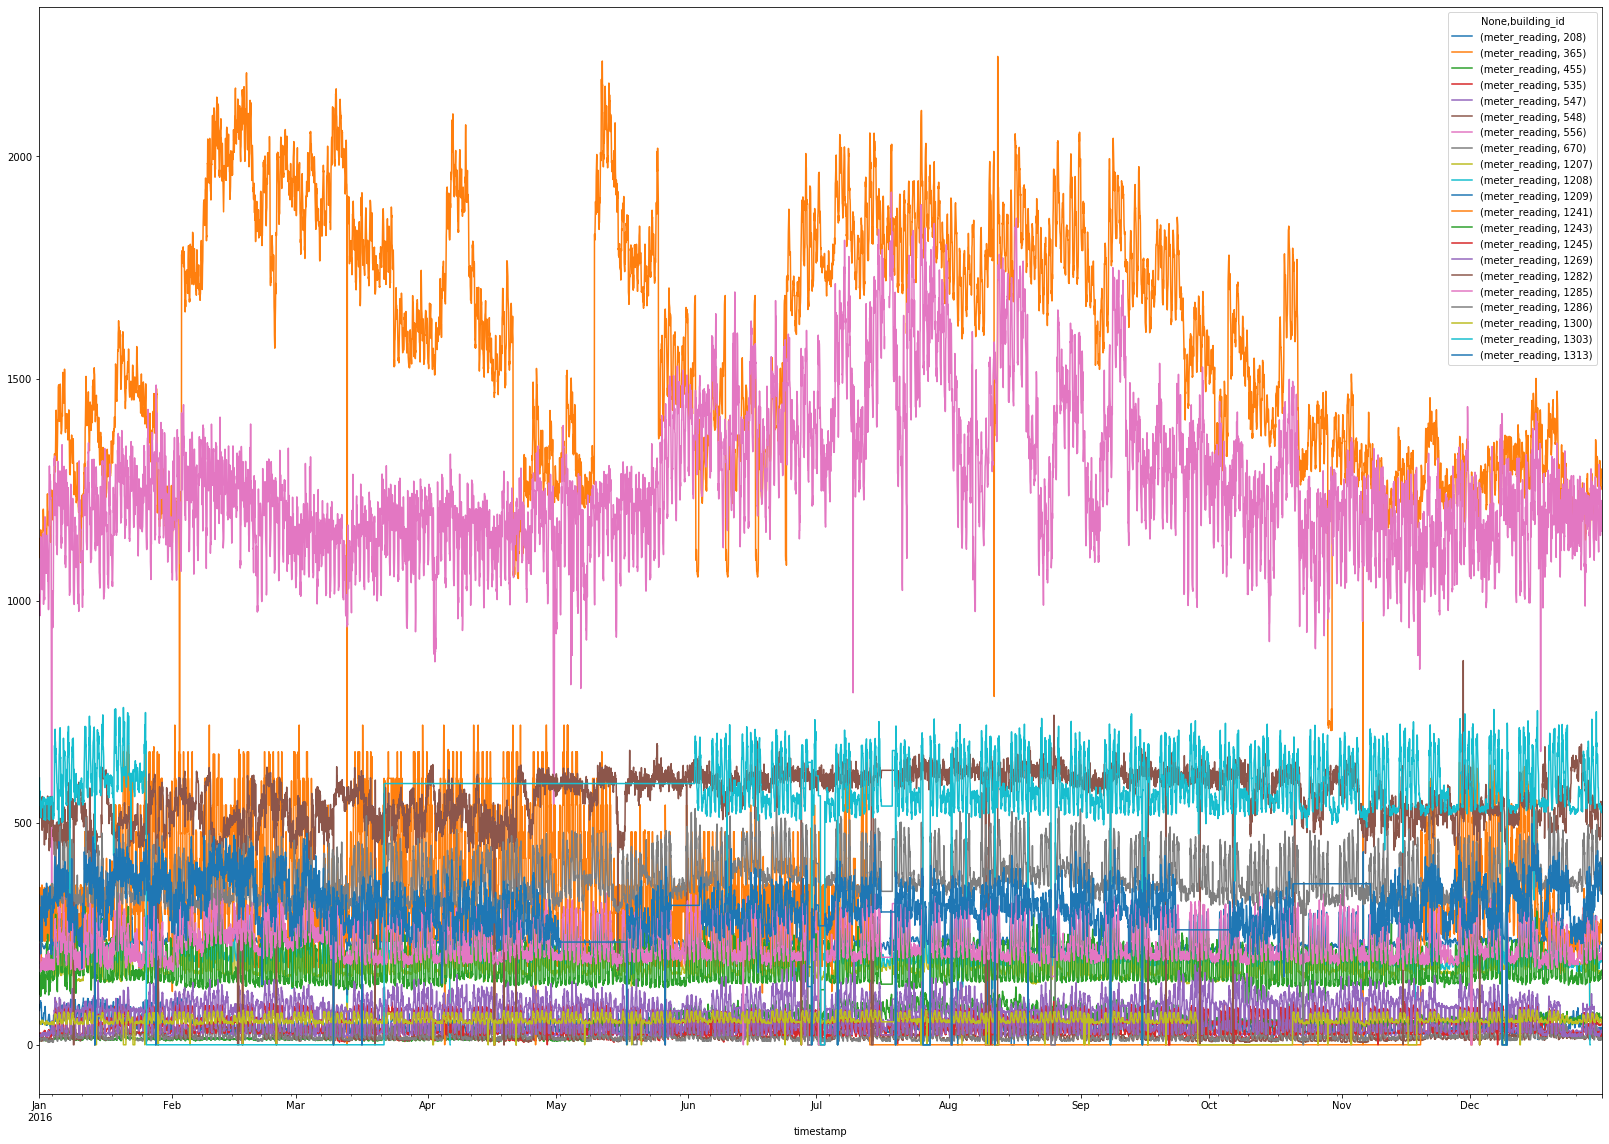

In [24]:
health_df_piv.plot(figsize=(28,20))

In [25]:
#sns.pairplot(health_df_piv['meter_reading'])

In [26]:
# Sorting buildings by size
hlth.sort_values(by=['square_feet'],ascending=True)

,site_id,building_id,primary_use,square_feet,year_built,floor_count
548,3,548,Healthcare,9813,2010.0,NaN
1282,14,1282,Healthcare,12500,NaN,NaN
535,3,535,Healthcare,15000,2010.0,NaN
670,5,670,Healthcare,18471,1966.0,1.0
547,3,547,Healthcare,23903,NaN,NaN
1300,14,1300,Healthcare,25609,NaN,NaN
455,3,455,Healthcare,29192,2014.0,NaN
1245,14,1245,Healthcare,35354,NaN,NaN
208,2,208,Healthcare,36904,1934.0,NaN
1388,15,1388,Healthcare,45465,1990.0,NaN


In [27]:
#Stationarity test
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [28]:
adf_test(health_df_piv['meter_reading'][455])

Augmented Dickey-Fuller Test: 
ADF test statistic        -2.458701
p-value                    0.125849
# lags used               31.000000
# observations          8750.000000
critical value (1%)       -3.431098
critical value (5%)       -2.861870
critical value (10%)      -2.566946
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [29]:
# Delete this as is non-stationary

In [30]:
# forward fill Nans

In [31]:
health_df_stat = health_df_piv.drop(columns = [455], level = 1)

In [32]:
health_df_stat.isnull().any()

               building_id
meter_reading  208             True
               365            False
               535             True
               547             True
               548             True
               556             True
               670            False
               1207            True
               1208            True
               1209            True
               1241            True
               1243           False
               1245           False
               1269           False
               1282           False
               1285           False
               1286           False
               1300           False
               1303           False
               1313           False
dtype: bool

In [33]:
health_df_stat.fillna(method='ffill', inplace = True)

In [34]:
health_df_stat.isnull().any()

               building_id
meter_reading  208            False
               365            False
               535            False
               547            False
               548            False
               556            False
               670            False
               1207           False
               1208           False
               1209           False
               1241           False
               1243           False
               1245           False
               1269           False
               1282           False
               1285           False
               1286           False
               1300           False
               1303           False
               1313           False
dtype: bool

In [35]:
health_df_stat.columns

MultiIndex([('meter_reading',  208),
            ('meter_reading',  365),
            ('meter_reading',  535),
            ('meter_reading',  547),
            ('meter_reading',  548),
            ('meter_reading',  556),
            ('meter_reading',  670),
            ('meter_reading', 1207),
            ('meter_reading', 1208),
            ('meter_reading', 1209),
            ('meter_reading', 1241),
            ('meter_reading', 1243),
            ('meter_reading', 1245),
            ('meter_reading', 1269),
            ('meter_reading', 1282),
            ('meter_reading', 1285),
            ('meter_reading', 1286),
            ('meter_reading', 1300),
            ('meter_reading', 1303),
            ('meter_reading', 1313)],
           names=[None, 'building_id'])

In [36]:
health_df_stat.columns = health_df_stat.columns.droplevel() # drop a level -> faster querying

In [37]:
health_df_stat.head()

building_id,208,365,535,547,548,556,670,1207,1208,1209,1241,1243,1245,1269,1282,1285,1286,1300,1303,1313
timestamp,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,77.290001,1139.520020,22.459999,21.889999,8.97,1013.780029,8.0,150.557007,186.531998,219.270004,234.179993,132.992996,25.4375,20.066200,537.0,198.0,338.109985,53.085499,600.554016,235.529999
2016-01-01 01:00:00,87.089996,1122.719971,22.120001,24.110001,9.49,988.380005,14.9,150.557007,186.531998,219.270004,294.156006,162.729996,24.0312,21.890301,512.0,227.0,324.510010,49.849701,539.424011,272.709991
2016-01-01 02:00:00,90.510002,1096.800049,23.440001,23.990000,9.52,996.250000,11.2,151.167007,183.479004,218.348007,354.152008,126.353996,25.7188,19.709000,541.0,209.0,323.820007,51.382500,564.181030,251.740005
2016-01-01 03:00:00,83.660004,1098.959961,26.150000,23.950001,9.04,966.219971,11.4,150.645004,184.302994,220.003006,294.121002,155.309998,22.2188,20.181700,522.0,199.0,318.720001,50.299801,555.093018,279.549988
2016-01-01 04:00:00,89.550003,1105.920044,26.400000,24.219999,9.72,984.390015,11.0,150.811005,183.656998,217.731003,294.101990,113.105003,21.8125,22.221500,531.0,177.0,314.950012,51.066200,570.804016,236.369995


In [38]:
# Split into Test Train -> how long to forecaste -> 7 days? = 168hrs

In [39]:
# Asses if this train/est is ok

In [40]:
len(health_df_stat)

8784

In [41]:
test_ind = 186

train = health_df_stat.iloc[:-test_ind]
test = health_df_stat.iloc[-test_ind:]

In [42]:
len(train)

8598

In [43]:
# Currently using most of data as training -> long fitting time -> can reduce

In [44]:
# SCALE

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train) #FIT TRAINING ONLY!

MinMaxScaler(copy=True, feature_range=(0, 1))

In [45]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [46]:
# Import TimeSeriesGenerator from TensorFlow-> Keras

In [47]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [93]:
# Define Generator Object
length = 168 # Length of the output sequences (in number of timesteps)
batch_size = 32 #Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

In [94]:
len(scaled_train)

8598

In [95]:
len(generator)

264

In [96]:
# First batch generator look like? -> size macthes number of hospitals in set (minus one, as I removed one)
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.73609525 0.5120794  0.26668248 ... 0.59524876 0.7204787  0.5054453 ]
Predict this y: 
 [[0.75533336 0.60644954 0.31049633 0.10438068 0.16604125 0.4333146
  0.33974266 0.4607891  0.6577059  0.542433   0.40853927 0.58477736
  0.685454   0.4083583  0.65433526 0.52130324 0.66467464 0.7568781
  0.830435   0.50857985]
 [0.83723813 0.5923209  0.30990264 0.10898571 0.15609756 0.42030576
  0.31156093 0.45438895 0.63983166 0.5358698  0.49194112 0.5029861
  0.72157973 0.39552936 0.64971095 0.5313283  0.62591004 0.68455917
  0.7575825  0.62333226]
 [0.7930476  0.5780846  0.3153645  0.11524381 0.1589118  0.4224516
  0.21292493 0.44534174 0.63409877 0.52852446 0.49194667 0.42806152
  0.73652935 0.37169728 0.6601156  0.52882206 0.6364518  0.6971887
  0.384085   0.68250686]
 [0.79285717 0.5844478  0.30681548 0.10945801 0.15196997 0.4279501
  0.20084706 0.44965813 0.62420934 0.52750766 0.40861565 0.38345268
  0.65275455 0.36552042 0.59768784 0.5814536  0.47007596 0.63539314
  0.784

In [97]:
# Generate Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [98]:
scaled_train.shape # Basicaly size of df

(8598, 20)

In [99]:
# define model
model = Sequential()

# Simple RNN layer
model.add(LSTM(256,input_shape=(length,scaled_train.shape[1])))

# Final Prediction (one neuron per feature)
model.add(Dense(scaled_train.shape[1]))

model.compile(optimizer='adam', loss='mse')

In [100]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 256)               283648    
_________________________________________________________________
dense_2 (Dense)              (None, 20)                5140      
Total params: 288,788
Trainable params: 288,788
Non-trainable params: 0
_________________________________________________________________


In [101]:
# Define early stopping function -> will use later...

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=1)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, 
                                           length=length, batch_size=batch_size)

In [102]:
# This is likely to take ages so will set epoch = 5 for now

# 60 Epochs will take around 10 hours
model.fit_generator(generator,epochs=5,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

#model.fit_generator(generator,epochs=5)



Epoch 1/5
264/264 [==============================] - 80s 303ms/step - loss: 0.0176 - val_loss: 0.0084
Epoch 2/5
264/264 [==============================] - 91s 345ms/step - loss: 0.0068 - val_loss: 0.0052
Epoch 3/5
264/264 [==============================] - 91s 345ms/step - loss: 0.0054 - val_loss: 0.0039
Epoch 4/5
264/264 [==============================] - 91s 345ms/step - loss: 0.0045 - val_loss: 0.0022
Epoch 5/5
264/264 [==============================] - 105s 397ms/step - loss: 0.0042 - val_loss: 0.0014


In [103]:
model.history.history.keys()

dict_keys(['loss', 'val_loss'])

In [104]:
# This is for when I use early stopping so i don't run simulations that last weeks

'''losses = pd.DataFrame(model.history.history)
losses.plot()'''

'losses = pd.DataFrame(model.history.history)\nlosses.plot()'

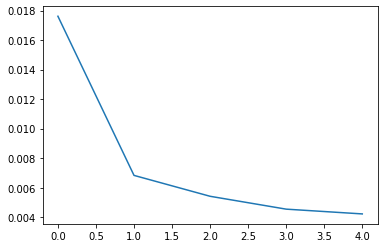

In [105]:
# Plot elbow method
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [106]:
# All stationary except for 455

In [107]:
# Evaluate against test data -> in batches

In [108]:
first_eval_batch = scaled_train[-length:]

In [109]:
first_eval_batch

array([[0.4117143 , 0.61626405, 0.64960814, ..., 0.6523833 , 0.71129364,
        0.709914  ],
       [0.47914287, 0.6285591 , 0.5938019 , ..., 0.6223124 , 0.7156221 ,
        0.77282596],
       [0.5207619 , 0.6187446 , 0.6094752 , ..., 0.6263715 , 0.7246308 ,
        0.69114697],
       ...,
       [0.37371433, 0.5323555 , 0.33163145, ..., 0.6229131 , 0.76476854,
        0.6444503 ],
       [0.39971432, 0.5278257 , 0.33614343, ..., 0.7047061 , 0.73421746,
        0.6532712 ],
       [0.41571432, 0.5289042 , 0.33590597, ..., 0.6197564 , 0.71316355,
        0.6693056 ]], dtype=float32)

In [110]:
first_eval_batch = first_eval_batch.reshape((1, length, scaled_train.shape[1]))

In [111]:
# Prediction on first batch

model.predict(first_eval_batch)

array([[0.4313483 , 0.5173832 , 0.39745593, 0.17867032, 0.23658124,
        0.5035526 , 0.37614885, 0.50892395, 0.5950658 , 0.5344985 ,
        0.30136502, 0.4649453 , 0.26926   , 0.12073764, 0.6071824 ,
        0.47960848, 0.60746753, 0.66632426, 0.79204327, 0.6820402 ]],
      dtype=float32)

In [112]:
scaled_test[0]

array([0.42171428, 0.538503  , 0.31358346, 0.20014168, 0.30168852,
       0.4954721 , 0.40617096, 0.53194106, 0.56475717, 0.4917471 ,
       0.27367648, 0.4437805 , 0.24509388, 0.11824287, 0.6612717 ,
       0.47619048, 0.6387963 , 0.6224632 , 0.7110237 , 0.68763065],
      dtype=float32)

In [113]:
# Iterative loop for feeding in sequential batches

n_features = scaled_train.shape[1]
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    print(current_pred)
    
    # store prediction
    test_predictions.append(current_pred) 
    print(current_pred)
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

[0.4313483  0.5173832  0.39745593 0.17867032 0.23658124 0.5035526
 0.37614885 0.50892395 0.5950658  0.5344985  0.30136502 0.4649453
 0.26926    0.12073764 0.6071824  0.47960848 0.60746753 0.66632426
 0.79204327 0.6820402 ]
[0.4313483  0.5173832  0.39745593 0.17867032 0.23658124 0.5035526
 0.37614885 0.50892395 0.5950658  0.5344985  0.30136502 0.4649453
 0.26926    0.12073764 0.6071824  0.47960848 0.60746753 0.66632426
 0.79204327 0.6820402 ]
[0.4476864  0.5164346  0.4190053  0.18329187 0.24971655 0.5034057
 0.3853012  0.51399463 0.6067551  0.5427087  0.3038052  0.46645167
 0.28353304 0.13604018 0.6053309  0.48016554 0.6025677  0.6679859
 0.7998184  0.6850357 ]
[0.4476864  0.5164346  0.4190053  0.18329187 0.24971655 0.5034057
 0.3853012  0.51399463 0.6067551  0.5427087  0.3038052  0.46645167
 0.28353304 0.13604018 0.6053309  0.48016554 0.6025677  0.6679859
 0.7998184  0.6850357 ]
[0.4635469  0.51584053 0.4411926  0.19002505 0.26212764 0.5029653
 0.39663365 0.52110875 0.6181331  0.551039

[0.5777518  0.4834183  0.5831741  0.18327649 0.26918712 0.4666971
 0.42065492 0.5123403  0.60791135 0.570055   0.3587315  0.57362896
 0.45209807 0.2561867  0.57115    0.5340879  0.63408023 0.708024
 0.9954533  0.7256276 ]
[0.5777518  0.4834183  0.5831741  0.18327649 0.26918712 0.4666971
 0.42065492 0.5123403  0.60791135 0.570055   0.3587315  0.57362896
 0.45209807 0.2561867  0.57115    0.5340879  0.63408023 0.708024
 0.9954533  0.7256276 ]
[0.58756334 0.4819563  0.5914142  0.18622193 0.27297154 0.46691537
 0.42685494 0.51561713 0.6101777  0.5739936  0.35295618 0.5695588
 0.44547126 0.24852514 0.5688555  0.5317652  0.6311247  0.70323884
 0.9987729  0.7242798 ]
[0.58756334 0.4819563  0.5914142  0.18622193 0.27297154 0.46691537
 0.42685494 0.51561713 0.6101777  0.5739936  0.35295618 0.5695588
 0.44547126 0.24852514 0.5688555  0.5317652  0.6311247  0.70323884
 0.9987729  0.7242798 ]
[0.5973862  0.48059842 0.6000914  0.18967293 0.27742502 0.4672903
 0.43480995 0.51961523 0.6133756  0.578543

[0.6429142  0.44966117 0.66055655 0.17025451 0.27861586 0.44392958
 0.49029937 0.51649547 0.6020206  0.5855049  0.35256514 0.62071145
 0.4934896  0.2653621  0.5541532  0.5546281  0.6441459  0.70392776
 1.0772583  0.7340107 ]
[0.6429142  0.44966117 0.66055655 0.17025451 0.27861586 0.44392958
 0.49029937 0.51649547 0.6020206  0.5855049  0.35256514 0.62071145
 0.4934896  0.2653621  0.5541532  0.5546281  0.6441459  0.70392776
 1.0772583  0.7340107 ]
[0.6462903  0.44809482 0.6634606  0.16876288 0.2787154  0.44308767
 0.4891032  0.51538354 0.60002685 0.58519983 0.34864336 0.6155909
 0.4890176  0.26126885 0.552482   0.5505127  0.64012194 0.69878626
 1.0760758  0.7330318 ]
[0.6462903  0.44809482 0.6634606  0.16876288 0.2787154  0.44308767
 0.4891032  0.51538354 0.60002685 0.58519983 0.34864336 0.6155909
 0.4890176  0.26126885 0.552482   0.5505127  0.64012194 0.69878626
 1.0760758  0.7330318 ]
[0.6502604  0.44661486 0.6669628  0.16797164 0.2794812  0.44245735
 0.48886734 0.5149308  0.59871656 0

[0.68579394 0.42316103 0.71806824 0.15665153 0.29506785 0.42884263
 0.5317853  0.5178089  0.59570575 0.5967268  0.31666517 0.62794775
 0.4858128  0.24487257 0.5363765  0.5495646  0.6340405  0.678463
 1.1066872  0.74062663]
[0.68579394 0.42316103 0.71806824 0.15665153 0.29506785 0.42884263
 0.5317853  0.5178089  0.59570575 0.5967268  0.31666517 0.62794775
 0.4858128  0.24487257 0.5363765  0.5495646  0.6340405  0.678463
 1.1066872  0.74062663]
[0.68604076 0.42191747 0.71867466 0.15402053 0.29397452 0.42783636
 0.52987564 0.51577806 0.5932129  0.59525037 0.3157245  0.62712437
 0.48547745 0.24457413 0.53572696 0.5480578  0.6327076  0.6765597
 1.1066264  0.7408445 ]
[0.68604076 0.42191747 0.71867466 0.15402053 0.29397452 0.42783636
 0.52987564 0.51577806 0.5932129  0.59525037 0.3157245  0.62712437
 0.48547745 0.24457413 0.53572696 0.5480578  0.6327076  0.6765597
 1.1066264  0.7408445 ]
[0.68665653 0.4207115  0.71951616 0.15159263 0.29313308 0.42691723
 0.527983   0.51391166 0.59085214 0.593

[0.7124142  0.40258992 0.75579184 0.13543783 0.3064325  0.4155772
 0.5466725  0.51097804 0.5821977  0.5990144  0.2815033  0.61743313
 0.4648093  0.22116253 0.5194835  0.5326089  0.6150433  0.64502716
 1.1144028  0.7464921 ]
[0.7124142  0.40258992 0.75579184 0.13543783 0.3064325  0.4155772
 0.5466725  0.51097804 0.5821977  0.5990144  0.2815033  0.61743313
 0.4648093  0.22116253 0.5194835  0.5326089  0.6150433  0.64502716
 1.1144028  0.7464921 ]
[0.71227205 0.40161124 0.75658095 0.13376954 0.3062533  0.41464964
 0.54698014 0.51012075 0.5810924  0.59847933 0.28125757 0.6187055
 0.4657251  0.22170246 0.519083   0.5328884  0.6152605  0.6446626
 1.1154933  0.7471991 ]
[0.71227205 0.40161124 0.75658095 0.13376954 0.3062533  0.41464964
 0.54698014 0.51012075 0.5810924  0.59847933 0.28125757 0.6187055
 0.4657251  0.22170246 0.519083   0.5328884  0.6152605  0.6446626
 1.1154933  0.7471991 ]
[0.7121269  0.40064552 0.75726193 0.13200009 0.30596545 0.41373357
 0.54692036 0.5091206  0.5798181  0.597

[0.72567976 0.3856719  0.778857   0.11104309 0.3126064  0.40188777
 0.5512653  0.5009621  0.5661951  0.59611326 0.26021045 0.61106026
 0.45060992 0.20615327 0.50569904 0.5198095  0.6006426  0.61725223
 1.1188837  0.7534371 ]
[0.72567976 0.3856719  0.778857   0.11104309 0.3126064  0.40188777
 0.5512653  0.5009621  0.5661951  0.59611326 0.26021045 0.61106026
 0.45060992 0.20615327 0.50569904 0.5198095  0.6006426  0.61725223
 1.1188837  0.7534371 ]
[0.7260881  0.3848752  0.78000253 0.11010507 0.3131678  0.4011681
 0.5524587  0.5008974  0.5659264  0.5963216  0.25956792 0.61165345
 0.45057184 0.20586836 0.5051376  0.51992923 0.6005856  0.61650443
 1.1196632  0.75397205]
[0.7260881  0.3848752  0.78000253 0.11010507 0.3131678  0.4011681
 0.5524587  0.5008974  0.5659264  0.5963216  0.25956792 0.61165345
 0.45057184 0.20586836 0.5051376  0.51992923 0.6005856  0.61650443
 1.1196632  0.75397205]
[0.7263715  0.38407734 0.7810316  0.10908357 0.31362614 0.4004217
 0.5535116  0.5007432  0.56556344 0.

[0.73239523 0.37070736 0.7951289  0.08883573 0.31839532 0.38792017
 0.5582588  0.4938386  0.55375147 0.5942057  0.25014773 0.6105994
 0.4428414  0.19709855 0.49413028 0.5134786  0.59189385 0.5953331
 1.1244605  0.76096267]
[0.73239523 0.37070736 0.7951289  0.08883573 0.31839532 0.38792017
 0.5582588  0.4938386  0.55375147 0.5942057  0.25014773 0.6105994
 0.4428414  0.19709855 0.49413028 0.5134786  0.59189385 0.5953331
 1.1244605  0.76096267]
[0.7329448  0.37000254 0.796072   0.08801131 0.31893724 0.3872936
 0.55900186 0.49379876 0.55346733 0.5944082  0.2495741  0.6103967
 0.4421626  0.19637474 0.4935039  0.51316154 0.59140295 0.594152
 1.1246679  0.76127505]
[0.7329448  0.37000254 0.796072   0.08801131 0.31893724 0.3872936
 0.55900186 0.49379876 0.55346733 0.5944082  0.2495741  0.6103967
 0.4421626  0.19637474 0.4935039  0.51316154 0.59140295 0.594152
 1.1246679  0.76127505]
[0.7334404  0.3692959  0.7969879  0.08718324 0.3194691  0.38665465
 0.5597949  0.49376923 0.55320036 0.59461325 

[0.73730534 0.35669285 0.80806637 0.06987389 0.32481566 0.37434286
 0.5680599  0.49022615 0.54515034 0.59455436 0.24704474 0.61063576
 0.43598187 0.18899405 0.48356384 0.50973237 0.58497757 0.57529056
 1.1289881  0.76765746]
[0.73730534 0.35669285 0.80806637 0.06987389 0.32481566 0.37434286
 0.5680599  0.49022615 0.54515034 0.59455436 0.24704474 0.61063576
 0.43598187 0.18899405 0.48356384 0.50973237 0.58497757 0.57529056
 1.1289881  0.76765746]
[0.7376352  0.35601583 0.808667   0.06900539 0.3251408  0.37370852
 0.5684188  0.4900791  0.54474086 0.59459096 0.2469402  0.6103641
 0.43542475 0.18843716 0.48301685 0.50940114 0.58448315 0.5741534
 1.1290159  0.76790625]
[0.7376352  0.35601583 0.808667   0.06900539 0.3251408  0.37370852
 0.5684188  0.4900791  0.54474086 0.59459096 0.2469402  0.6103641
 0.43542475 0.18843716 0.48301685 0.50940114 0.58448315 0.5741534
 1.1290159  0.76790625]
[0.7379729  0.35533923 0.80927676 0.0681579  0.32548407 0.37307662
 0.5688263  0.48995978 0.54436284 0.5

[0.7417219  0.34170464 0.81904984 0.05153488 0.33123234 0.3599954
 0.57853025 0.48824516 0.53775257 0.59589255 0.25013986 0.60915273
 0.42833322 0.18036932 0.47286305 0.50619483 0.57755274 0.5539514
 1.1315581  0.77361345]
[0.7417219  0.34170464 0.81904984 0.05153488 0.33123234 0.3599954
 0.57853025 0.48824516 0.53775257 0.59589255 0.25013986 0.60915273
 0.42833322 0.18036932 0.47286305 0.50619483 0.57755274 0.5539514
 1.1315581  0.77361345]
[0.74189234 0.34102938 0.81945825 0.05073076 0.33146793 0.35935843
 0.5788941  0.4881474  0.53740317 0.5959239  0.25043643 0.609024
 0.42798764 0.1799972  0.47240227 0.50601095 0.57719326 0.5529847
 1.1315932  0.7738449 ]
[0.74189234 0.34102938 0.81945825 0.05073076 0.33146793 0.35935843
 0.5788941  0.4881474  0.53740317 0.5959239  0.25043643 0.609024
 0.42798764 0.1799972  0.47240227 0.50601095 0.57719326 0.5529847
 1.1315932  0.7738449 ]
[0.7420732  0.3403548  0.81987077 0.04993894 0.3317112  0.35872534
 0.5792701  0.48806152 0.53706646 0.5959662

[0.7447398  0.32814535 0.82663035 0.03657533 0.336076   0.3473874
 0.5876404  0.4875512  0.53223854 0.5974593  0.25809014 0.607658
 0.4224059  0.17357054 0.46412084 0.5037826  0.5714305  0.53587186
 1.13271    0.77811545]
[0.7447398  0.32814535 0.82663035 0.03657533 0.336076   0.3473874
 0.5876404  0.4875512  0.53223854 0.5974593  0.25809014 0.607658
 0.4224059  0.17357054 0.46412084 0.5037826  0.5714305  0.53587186
 1.13271    0.77811545]
[0.74483925 0.32746577 0.8269391  0.03584713 0.3362707  0.34676096
 0.58806014 0.48751745 0.53196585 0.5975203  0.25862485 0.6076152
 0.42217734 0.17329243 0.46371683 0.50369376 0.57115704 0.535022
 1.1327573  0.7783269 ]
[0.74483925 0.32746577 0.8269391  0.03584713 0.3362707  0.34676096
 0.58806014 0.48751745 0.53196585 0.5975203  0.25862485 0.6076152
 0.42217734 0.17329243 0.46371683 0.50369376 0.57115704 0.535022
 1.1327573  0.7783269 ]
[0.7449422  0.32678685 0.8272453  0.03512343 0.33646384 0.3461372
 0.5884727  0.48748443 0.5316937  0.5975812  0

In [114]:
# Looking at the test_preds
test_predictions

[array([0.4313483 , 0.5173832 , 0.39745593, 0.17867032, 0.23658124,
        0.5035526 , 0.37614885, 0.50892395, 0.5950658 , 0.5344985 ,
        0.30136502, 0.4649453 , 0.26926   , 0.12073764, 0.6071824 ,
        0.47960848, 0.60746753, 0.66632426, 0.79204327, 0.6820402 ],
       dtype=float32),
 array([0.4476864 , 0.5164346 , 0.4190053 , 0.18329187, 0.24971655,
        0.5034057 , 0.3853012 , 0.51399463, 0.6067551 , 0.5427087 ,
        0.3038052 , 0.46645167, 0.28353304, 0.13604018, 0.6053309 ,
        0.48016554, 0.6025677 , 0.6679859 , 0.7998184 , 0.6850357 ],
       dtype=float32),
 array([0.4635469 , 0.51584053, 0.4411926 , 0.19002505, 0.26212764,
        0.5029653 , 0.39663365, 0.52110875, 0.6181331 , 0.55103916,
        0.30882227, 0.47511995, 0.3028301 , 0.15384948, 0.60248977,
        0.48441383, 0.60265744, 0.67339516, 0.8125923 , 0.68886435],
       dtype=float32),
 array([0.47848502, 0.5154363 , 0.4629126 , 0.19764894, 0.27348033,
        0.50211203, 0.40857714, 0.52857214, 

In [115]:
scaled_test

array([[0.42171428, 0.538503  , 0.31358346, ..., 0.6224632 , 0.7110237 ,
        0.68763065],
       [0.46580955, 0.54119927, 0.2882926 , ..., 0.59840554, 0.7093091 ,
        0.70109314],
       [0.4549524 , 0.5360225 , 0.28686774, ..., 0.63193476, 0.71205735,
        0.72355735],
       ...,
       [0.27      , 0.5825065 , 0.5404892 , ..., 0.66561353, 0.688192  ,
        0.6817835 ],
       [0.26009524, 0.5803494 , 0.54428875, ..., 0.6433617 , 0.7056417 ,
        0.7675213 ],
       [0.2632381 , 0.5742019 , 0.5552125 , ..., 0.6119374 , 0.70526767,
        0.74135995]], dtype=float32)

In [116]:
# Need to invert the scale transfrom in order to predict true performance

In [117]:
true_predictions = scaler.inverse_transform(test_predictions)

In [118]:
true_predictions # Notice magnitude change!

array([[  45.29156914, 1151.32252324,   33.47373814, ...,   53.9092988 ,
         601.46498329,  339.43776172],
       [  47.00707062, 1149.21160501,   35.28862639, ...,   54.0437361 ,
         607.36929098,  340.92855764],
       [  48.67242285, 1147.8896118 ,   37.15724015, ...,   54.48137343,
         617.06960979,  342.83399749],
       ...,
       [  78.19767296,  730.2152932 ,   69.61880769, ...,   43.35498229,
         860.16183224,  387.25248384],
       [  78.20811837,  728.70303218,   69.64481079, ...,   43.28622531,
         860.19777091,  387.35773185],
       [  78.21892678,  727.19223016,   69.67059804, ...,   43.21723686,
         860.228097  ,  387.46093304]])

In [119]:
test

building_id,208,365,535,547,548,556,670,1207,1208,1209,1241,1243,1245,1269,1282,1285,1286,1300,1303,1313
timestamp,,,,,,,,,,,,,,,,,,,,
2016-12-24 06:00:00,44.279999,1198.319946,26.410000,31.410000,21.360001,1129.699951,20.500000,182.268005,175.548004,213.761002,197.0,140.369995,24.5937,25.232201,572.0,190.0,362.369995,50.360699,539.940002,342.220001
2016-12-24 07:00:00,48.910000,1204.319946,24.280001,31.870001,18.170000,1250.560059,22.600000,179.981995,174.679993,217.645004,202.0,138.121002,28.5312,21.553699,553.0,179.0,362.859985,48.414299,538.638000,348.920013
2016-12-24 08:00:00,47.770000,1192.800049,24.160000,32.419998,16.660000,1230.189941,24.000000,179.843994,175.940002,218.153000,190.0,149.860992,24.9375,24.064100,566.0,180.0,361.700012,51.126999,540.724976,360.100006
2016-12-24 09:00:00,48.439999,1186.079956,24.230000,31.610001,17.639999,1207.199951,22.200001,181.268997,175.156998,216.671005,210.0,148.100998,26.3125,24.343201,565.0,182.0,369.279999,49.861900,545.685974,302.859985
2016-12-24 10:00:00,50.639999,1225.680054,24.440001,29.690001,18.520000,1231.869995,25.100000,181.503006,178.022995,220.266006,206.0,143.563004,26.7500,25.877899,548.0,178.0,372.119995,50.360699,539.898987,290.720001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,38.230000,1270.319946,45.349998,31.330000,19.270000,1225.359985,16.000000,165.285995,191.494995,228.130005,262.0,163.959000,20.0625,29.116400,546.0,194.0,373.799988,56.260399,533.294983,347.579987
2016-12-31 20:00:00,39.459999,1281.359985,47.139999,32.380001,18.840000,1178.640015,16.000000,166.059998,188.776993,228.593002,252.0,159.632004,23.0312,29.281200,537.0,195.0,367.019989,52.562401,529.398987,344.549988
2016-12-31 21:00:00,28.350000,1296.239990,45.520000,31.620001,19.000000,1187.449951,16.000000,165.654007,189.929993,227.707993,252.0,167.992004,21.1250,30.658199,536.0,218.0,376.089996,53.851799,522.601990,339.309998


In [120]:
true_predictions = pd.DataFrame(data=true_predictions,columns=test.columns)

In [121]:
true_predictions.index = test.index

In [122]:
true_predictions

building_id,208,365,535,547,548,556,670,1207,1208,1209,1241,1243,1245,1269,1282,1285,1286,1300,1303,1313
timestamp,,,,,,,,,,,,,,,,,,,,
2016-12-24 06:00:00,45.291569,1151.322523,33.473738,29.591589,17.889781,1142.352881,19.008573,174.381259,184.969064,232.344905,216.930986,147.064516,27.018625,25.764568,525.212773,191.363783,344.598123,53.909299,601.464983,339.437762
2016-12-24 07:00:00,47.007071,1149.211605,35.288626,29.982989,18.589894,1142.122817,19.463240,176.118715,188.602545,235.913847,218.687499,147.540994,28.450839,29.030022,523.611227,191.586052,341.818580,54.043736,607.369291,340.928558
2016-12-24 08:00:00,48.672423,1147.889612,37.157240,30.553221,19.251405,1141.433183,20.026209,178.556344,192.139275,239.535075,222.298928,150.282813,30.387184,32.830402,521.153662,193.281120,341.869500,54.481373,617.069610,342.833997
2016-12-24 09:00:00,50.240925,1146.990068,38.986498,31.198889,19.856503,1140.097127,20.619533,181.113654,195.419790,243.197785,227.503188,154.687139,32.671184,37.004429,518.893410,196.381791,344.192617,55.179186,629.247660,345.369472
2016-12-24 10:00:00,51.623694,1145.820076,40.670728,31.832866,20.371534,1137.892146,21.174728,183.402478,198.176036,246.535532,233.900230,160.257821,35.134339,41.310582,516.936783,200.541545,348.141647,56.053023,642.823336,348.324989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,78.177289,733.243131,69.565868,17.681750,23.171592,899.792509,29.471827,167.080299,165.608276,259.658357,185.024227,192.224387,42.430582,37.156137,402.166159,201.074244,324.457845,43.492004,860.073389,387.036470
2016-12-31 20:00:00,78.187447,731.728682,69.592539,17.619542,23.182330,898.804584,29.493665,167.069383,165.524458,259.686651,185.399711,192.216072,42.408372,37.097514,401.814816,201.042661,324.307788,43.423556,860.120553,387.145397
2016-12-31 21:00:00,78.197673,730.215293,69.618808,17.557565,23.192852,897.820019,29.514966,167.057956,165.439973,259.713778,185.780515,192.205269,42.385898,37.038739,401.464531,201.009247,324.155397,43.354982,860.161832,387.252484


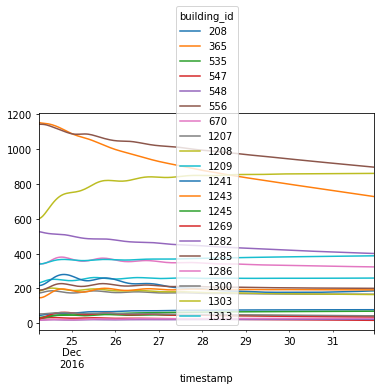

In [123]:
true_predictions.plot()

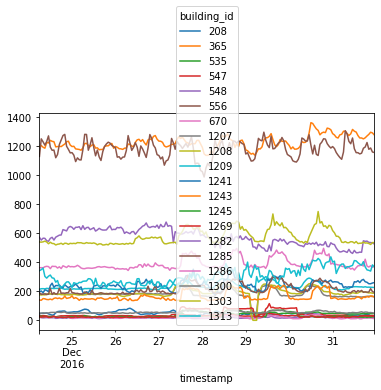

In [124]:
test.plot()

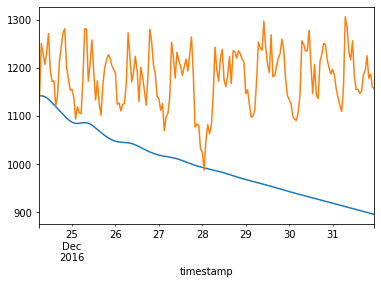

In [125]:
true_predictions[556].plot()
test[556].plot()

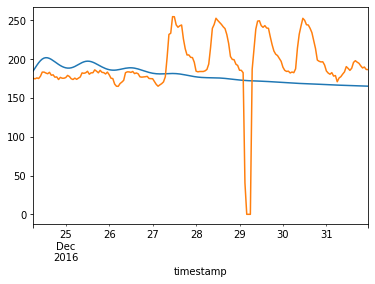

In [126]:
true_predictions[1208].plot()
test[1208].plot()

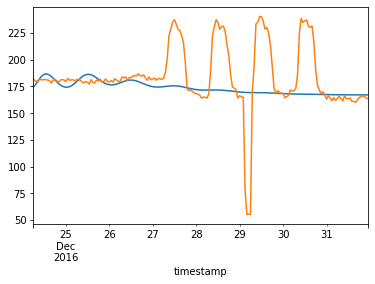

In [127]:
true_predictions[1207].plot()
test[1207].plot()

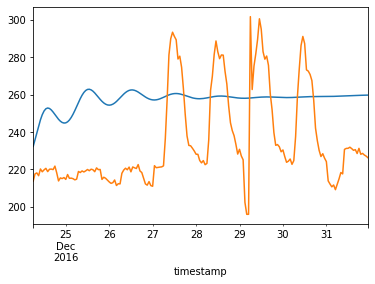

In [128]:
true_predictions[1209].plot()
test[1209].plot()

In [129]:
true_predictions

building_id,208,365,535,547,548,556,670,1207,1208,1209,1241,1243,1245,1269,1282,1285,1286,1300,1303,1313
timestamp,,,,,,,,,,,,,,,,,,,,
2016-12-24 06:00:00,45.291569,1151.322523,33.473738,29.591589,17.889781,1142.352881,19.008573,174.381259,184.969064,232.344905,216.930986,147.064516,27.018625,25.764568,525.212773,191.363783,344.598123,53.909299,601.464983,339.437762
2016-12-24 07:00:00,47.007071,1149.211605,35.288626,29.982989,18.589894,1142.122817,19.463240,176.118715,188.602545,235.913847,218.687499,147.540994,28.450839,29.030022,523.611227,191.586052,341.818580,54.043736,607.369291,340.928558
2016-12-24 08:00:00,48.672423,1147.889612,37.157240,30.553221,19.251405,1141.433183,20.026209,178.556344,192.139275,239.535075,222.298928,150.282813,30.387184,32.830402,521.153662,193.281120,341.869500,54.481373,617.069610,342.833997
2016-12-24 09:00:00,50.240925,1146.990068,38.986498,31.198889,19.856503,1140.097127,20.619533,181.113654,195.419790,243.197785,227.503188,154.687139,32.671184,37.004429,518.893410,196.381791,344.192617,55.179186,629.247660,345.369472
2016-12-24 10:00:00,51.623694,1145.820076,40.670728,31.832866,20.371534,1137.892146,21.174728,183.402478,198.176036,246.535532,233.900230,160.257821,35.134339,41.310582,516.936783,200.541545,348.141647,56.053023,642.823336,348.324989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,78.177289,733.243131,69.565868,17.681750,23.171592,899.792509,29.471827,167.080299,165.608276,259.658357,185.024227,192.224387,42.430582,37.156137,402.166159,201.074244,324.457845,43.492004,860.073389,387.036470
2016-12-31 20:00:00,78.187447,731.728682,69.592539,17.619542,23.182330,898.804584,29.493665,167.069383,165.524458,259.686651,185.399711,192.216072,42.408372,37.097514,401.814816,201.042661,324.307788,43.423556,860.120553,387.145397
2016-12-31 21:00:00,78.197673,730.215293,69.618808,17.557565,23.192852,897.820019,29.514966,167.057956,165.439973,259.713778,185.780515,192.205269,42.385898,37.038739,401.464531,201.009247,324.155397,43.354982,860.161832,387.252484


In [130]:
test

building_id,208,365,535,547,548,556,670,1207,1208,1209,1241,1243,1245,1269,1282,1285,1286,1300,1303,1313
timestamp,,,,,,,,,,,,,,,,,,,,
2016-12-24 06:00:00,44.279999,1198.319946,26.410000,31.410000,21.360001,1129.699951,20.500000,182.268005,175.548004,213.761002,197.0,140.369995,24.5937,25.232201,572.0,190.0,362.369995,50.360699,539.940002,342.220001
2016-12-24 07:00:00,48.910000,1204.319946,24.280001,31.870001,18.170000,1250.560059,22.600000,179.981995,174.679993,217.645004,202.0,138.121002,28.5312,21.553699,553.0,179.0,362.859985,48.414299,538.638000,348.920013
2016-12-24 08:00:00,47.770000,1192.800049,24.160000,32.419998,16.660000,1230.189941,24.000000,179.843994,175.940002,218.153000,190.0,149.860992,24.9375,24.064100,566.0,180.0,361.700012,51.126999,540.724976,360.100006
2016-12-24 09:00:00,48.439999,1186.079956,24.230000,31.610001,17.639999,1207.199951,22.200001,181.268997,175.156998,216.671005,210.0,148.100998,26.3125,24.343201,565.0,182.0,369.279999,49.861900,545.685974,302.859985
2016-12-24 10:00:00,50.639999,1225.680054,24.440001,29.690001,18.520000,1231.869995,25.100000,181.503006,178.022995,220.266006,206.0,143.563004,26.7500,25.877899,548.0,178.0,372.119995,50.360699,539.898987,290.720001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,38.230000,1270.319946,45.349998,31.330000,19.270000,1225.359985,16.000000,165.285995,191.494995,228.130005,262.0,163.959000,20.0625,29.116400,546.0,194.0,373.799988,56.260399,533.294983,347.579987
2016-12-31 20:00:00,39.459999,1281.359985,47.139999,32.380001,18.840000,1178.640015,16.000000,166.059998,188.776993,228.593002,252.0,159.632004,23.0312,29.281200,537.0,195.0,367.019989,52.562401,529.398987,344.549988
2016-12-31 21:00:00,28.350000,1296.239990,45.520000,31.620001,19.000000,1187.449951,16.000000,165.654007,189.929993,227.707993,252.0,167.992004,21.1250,30.658199,536.0,218.0,376.089996,53.851799,522.601990,339.309998


In [131]:
true_predictions

building_id,208,365,535,547,548,556,670,1207,1208,1209,1241,1243,1245,1269,1282,1285,1286,1300,1303,1313
timestamp,,,,,,,,,,,,,,,,,,,,
2016-12-24 06:00:00,45.291569,1151.322523,33.473738,29.591589,17.889781,1142.352881,19.008573,174.381259,184.969064,232.344905,216.930986,147.064516,27.018625,25.764568,525.212773,191.363783,344.598123,53.909299,601.464983,339.437762
2016-12-24 07:00:00,47.007071,1149.211605,35.288626,29.982989,18.589894,1142.122817,19.463240,176.118715,188.602545,235.913847,218.687499,147.540994,28.450839,29.030022,523.611227,191.586052,341.818580,54.043736,607.369291,340.928558
2016-12-24 08:00:00,48.672423,1147.889612,37.157240,30.553221,19.251405,1141.433183,20.026209,178.556344,192.139275,239.535075,222.298928,150.282813,30.387184,32.830402,521.153662,193.281120,341.869500,54.481373,617.069610,342.833997
2016-12-24 09:00:00,50.240925,1146.990068,38.986498,31.198889,19.856503,1140.097127,20.619533,181.113654,195.419790,243.197785,227.503188,154.687139,32.671184,37.004429,518.893410,196.381791,344.192617,55.179186,629.247660,345.369472
2016-12-24 10:00:00,51.623694,1145.820076,40.670728,31.832866,20.371534,1137.892146,21.174728,183.402478,198.176036,246.535532,233.900230,160.257821,35.134339,41.310582,516.936783,200.541545,348.141647,56.053023,642.823336,348.324989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,78.177289,733.243131,69.565868,17.681750,23.171592,899.792509,29.471827,167.080299,165.608276,259.658357,185.024227,192.224387,42.430582,37.156137,402.166159,201.074244,324.457845,43.492004,860.073389,387.036470
2016-12-31 20:00:00,78.187447,731.728682,69.592539,17.619542,23.182330,898.804584,29.493665,167.069383,165.524458,259.686651,185.399711,192.216072,42.408372,37.097514,401.814816,201.042661,324.307788,43.423556,860.120553,387.145397
2016-12-31 21:00:00,78.197673,730.215293,69.618808,17.557565,23.192852,897.820019,29.514966,167.057956,165.439973,259.713778,185.780515,192.205269,42.385898,37.038739,401.464531,201.009247,324.155397,43.354982,860.161832,387.252484


In [1]:
scaled_test.plot()

NameError: name 'scaled_test' is not defined